In [1]:
import mltrainer
assert mltrainer.__version__ >= "0.2.5"

In [2]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

from src import datasets, metrics
from mltrainer.transformer import print_cpu_memory_usage


In [3]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = "cpu"

In [4]:
import tomllib

datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


Lets test the big dataset

In [5]:
trainfile = datadir / (config['arrhythmia'] + '_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(WindowsPath('../data/heart_big_train.parq'),
 WindowsPath('../data/heart_big_test.parq'))

Load the data

In [6]:
traindataset = datasets.HeartDataset1D(trainfile, target="target")
testdataset = datasets.HeartDataset1D(testfile, target="target")
traindataset, testdataset

(Heartdataset (len 87554), Heartdataset (len 21892))

Visualise it as 1D data

torch.Size([192, 1]) tensor(0)


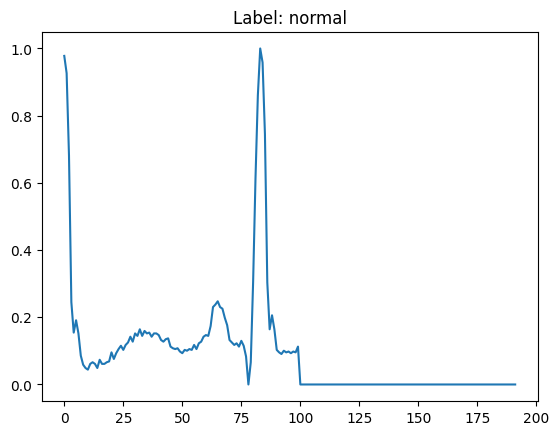

In [7]:
x, y = traindataset[0]
viz = x.squeeze().cpu().numpy()
sns.lineplot(x=range(len(viz)), y=viz)
title = 'normal' if y == 0 else 'abnormal'
plt.title(f"Label: {title}");
print(x.shape, y)

Set up the streamer

In [8]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(2736, 684)

In [9]:
print_cpu_memory_usage()

Current process memory usage: 775.60 MB


We can import the transformer architecture from `mltrainer`, where i implemented a memory-efficient version of the transformer architecture.

In [10]:
from mltrainer.transformer import Transformer

Note, the layers have different assumptions about the data structure:
- streamer:         (batch, seq_len, channels)
- conv1d:           (batch, channels, seq_len)
- pos_encoding:     (batch, seq_len, channels)
- gru (batchfirst): (batch, seq_len, channels)
- attention:        (batch, seq_len, channels)

As you can see, its only the conv1d layer that expects channels as the second dimension. Using a conv1d layer you
will need to transpose the dimensions, I show how to do that in the `mltrainer.transfomer.forward` method.

Again, the strategy of creating a block helps us stack the architecture more easily.
Lets start with a very basic config.

In [11]:
config = {
    "hidden": 16,
    "dropout": 0.1,
    "output": 5,
    "num_heads": 2,
    "num_blocks": 2,
}
model = Transformer(config)

Check if it works

In [12]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 192, 1]), torch.Size([32]))

Shapes look good

In [13]:
yhat = model(x)
yhat.shape

torch.Size([32, 5])

Lets test the metrics for the untrained model

In [14]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()
metrics_list = [f1micro, f1macro, precision, recall, accuracy]

In [15]:
for metric in metrics_list:
    print(f"{metric}:", metric(y, yhat))

F1Score_micro: 0.125
F1Score_macro: 0.1111111111111111
Precision_micro: 0.125
Recall_macro: 0.5
Accuracy: 0.125


And the memory

In [16]:
print_cpu_memory_usage()

Current process memory usage: 772.98 MB


In [17]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("Transformer")

2025/06/27 18:29:54 INFO mlflow.tracking.fluent: Experiment with name 'Transformer' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:c:/Users/vmgir/Documents/repositories/MADS-exam-25/notebooks/mlruns/5', creation_time=1751041794884, experiment_id='5', last_update_time=1751041794884, lifecycle_stage='active', name='Transformer', tags={}>

We want to have feedback more often, so lets test metrics every 1/5th of the dataset

In [18]:
steps = len(trainstreamer) // 5
steps

547

In [19]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=3,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=steps,
        valid_steps=steps,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        device=device,
        )
    trainer.loop()

2025-06-27 18:29:55.239 | INFO     | mltrainer.trainer:dir_add_timestamp:23 - Logging to logs\heart1D\20250627-182955
100%|██████████| 547/547 [00:15<00:00, 35.09it/s]
2025-06-27 18:30:17.059 | INFO     | mltrainer.trainer:report:198 - Epoch 0 train 0.6045 test 0.4705 metric ['0.8589', '0.8589', '0.4236', '0.8589', '0.4540']
100%|██████████| 547/547 [00:15<00:00, 36.37it/s]
2025-06-27 18:30:35.578 | INFO     | mltrainer.trainer:report:198 - Epoch 1 train 0.4292 test 0.3448 metric ['0.9088', '0.9088', '0.5978', '0.9088', '0.5959']
100%|██████████| 547/547 [00:14<00:00, 37.01it/s]
2025-06-27 18:30:53.961 | INFO     | mltrainer.trainer:report:198 - Epoch 2 train 0.3586 test 0.3168 metric ['0.9094', '0.9094', '0.6165', '0.9094', '0.6289']
100%|██████████| 3/3 [00:56<00:00, 18.69s/it]


In [20]:
print_cpu_memory_usage()

Current process memory usage: 897.54 MB


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

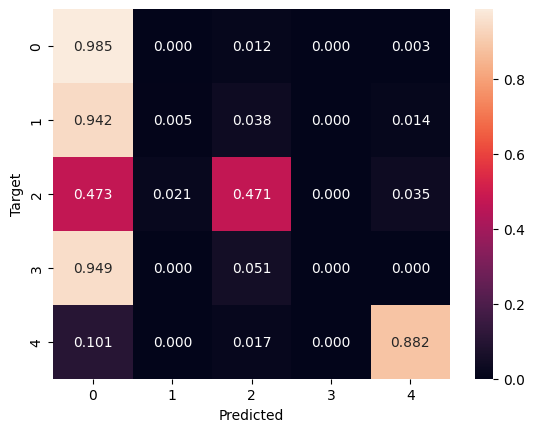

In [21]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
model.to("cpu")
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")